In [ ]:
!pip install xgboost

In [ ]:
import os
import pathlib
import warnings
from joblib import load

import pandas as pd
import numpy as np
import json

# modelling
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# plotting
from mplsoccer import Pitch
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [73]:
df = pd.DataFrame()
file_name = 'possession_chains_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
df = df.reset_index()

In [74]:
df.head()

,level_0,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,...,possession_chain,possession_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,...,0,1609,0.0,0,51.45,0.68,32.55,19.04,34.68,14.96
1,1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,...,0,1609,0.0,0,32.55,19.04,53.55,17.00,14.96,17.00
2,2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,...,0,1609,0.0,0,53.55,17.00,36.75,14.28,17.00,19.72
3,3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,...,0,1609,0.0,0,36.75,14.28,43.05,30.60,19.72,3.40
4,4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,...,0,1609,0.0,0,43.05,30.60,75.60,25.84,3.40,8.16


In [75]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#1 variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df.head(3)

,level_0,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
0,0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,...,34486.806375,720.4617,20172.9276,15.05112,421.43136,11800.07808,0.314432,8.804096,246.514688,6902.411264
1,1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,...,153560.113875,54599.1516,48749.2425,19413.03168,17333.06400,15475.95000,6902.411264,6162.867200,5502.560000,4913.000000
2,2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,...,49633.171875,22959.5625,19286.0325,10620.75000,8921.43000,7494.00120,4913.000000,4126.920000,3466.612800,2911.954752


In [76]:
var

['x0',
 'x1',
 'c0',
 'c1',
 'x0x0',
 'x0x1',
 'x0c0',
 'x0c1',
 'x1x1',
 'x1c0',
 'x1c1',
 'c0c0',
 'c0c1',
 'c1c1',
 'x0x0x0',
 'x0x0x1',
 'x0x0c0',
 'x0x0c1',
 'x0x1x1',
 'x0x1c0',
 'x0x1c1',
 'x0c0c0',
 'x0c0c1',
 'x0c1c1',
 'x1x1x1',
 'x1x1c0',
 'x1x1c1',
 'x1c0c0',
 'x1c0c1',
 'x1c1c1',
 'c0c0c0',
 'c0c0c1',
 'c0c1c1',
 'c1c1c1']

In [77]:
#predict if ended with shot
passes = df.loc[df["eventName"].isin(["Pass"])]
X1 = passes[var].values
y1 = passes["shot_end"].values

#path to saved model
path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'models', 'xgb_model_Germany.pkl')
xgb_model = load(path_model)

#predict probability of shot ended
y_pred_shot = xgb_model.predict(X1)
passes["shot_prob"] = y_pred_shot

#OLS
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred_goal = lr.predict(X2)
shot_ended["xG_pred"] = y_pred_goal

#calculate xGchain
shot_ended["xT"] = shot_ended["shot_prob"]*shot_ended["xG_pred"]
shot_ended[["shot_prob", "xG_pred", "xT"]].head(5)

,shot_prob,xG_pred,xT
19,0.023747,0.091335,0.002169
20,0.026194,0.098066,0.002569
25,0.167415,0.118235,0.019794
28,0.122330,0.088877,0.010872
29,0.127929,0.107229,0.013718


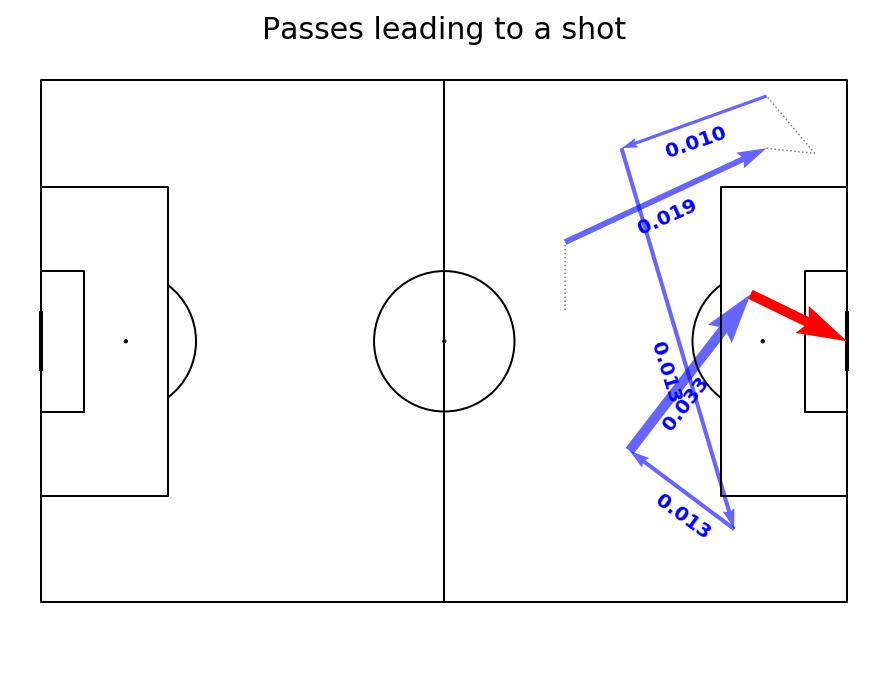

In [78]:
chain = df.loc[df["possession_chain"] == 4]

#get passes
passes_in = shot_ended.loc[df["possession_chain"] == 4]
max_value = passes_in["xT"].max()
#get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]
#plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#add size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    #adjust the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    #get angle
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi
    #plot lines on the pitch
    pitch.arrows(row.x0, row.y0, row.x1, row.y1, alpha=0.6, width=line_width, zorder=2, color="blue", ax=ax["pitch"])
    #annotate text
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], 
                     fontweight="bold", color="blue", zorder=4, fontsize=20, rotation=int(angle))

#shot
pitch.arrows(shot.x0, shot.y0, shot.x1, shot.y1, width=line_width, color="red", ax=ax['pitch'], zorder=3)
#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color="grey", linewidth=1.5, linestyle='dotted', ax=ax['pitch'])

ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

In [80]:
summary = shot_ended[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()
#add player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]
summary = summary.merge(to_merge, how = "left", on = ["playerId"])

#get minutes
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', "minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_p90"] = summary["xT"]*90/summary["minutesPlayed"]

#adjusting for possession
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', "minutes_played", 'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
#adjust per possession
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possession"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
250,E. Hazard,0.391693
22,M. Özil,0.347561
30,A. Sánchez,0.317966
39,Philippe Coutinho,0.289629
329,A. Martial,0.272560
